In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
! kaggle datasets download -d arjuntejaswi/plant-village

plant-village.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zf = "/content/plant-village.zip"
target_dir = "/content/plant-disease"

zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

## Importing Essential Libraries

In [85]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [86]:
# making some constants
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [87]:
import os, shutil
# os.mkdir("/content/potato-disease/PlantVillage/Potato")

source = "/content/plant-disease/PlantVillage"
destination = "/content/plant-disease/Potato"
for f in os.listdir(source):
  if "Potato" in f:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    shutil.move(src_path, dst_path)

Error: ignored

In [88]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/plant-disease/PlantVillage",
    seed=123,
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

classNames = dataset.class_names
classNames

Found 20638 files belonging to 15 classes.


['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [89]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/plant-disease/Potato",
    seed=123,
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

classNames = dataset.class_names
classNames

Found 4304 files belonging to 3 classes.


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [90]:
class_names = classNames[2:5]
class_names

['Potato___healthy']

In [91]:
len(dataset)

135

In [92]:
68*32

2176

In [93]:
for image_batch, labels_batch in dataset.take(1): # .take(1) will give one batch
    # print(image_batch[0].numpy()) # print 1st image
    print(image_batch.shape)
    # print(labels_batch)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[0 0 0 0 0 2 2 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 2 1 0 1 1 0]


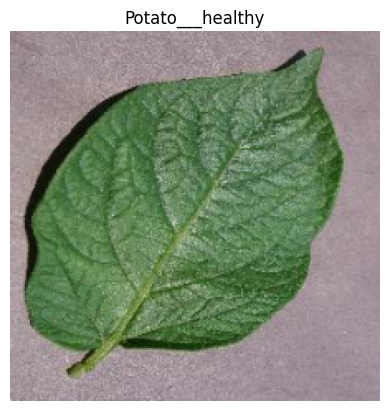

In [94]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8")) # print 1st image
    plt.title(classNames[labels_batch[0]])
    plt.axis("off")

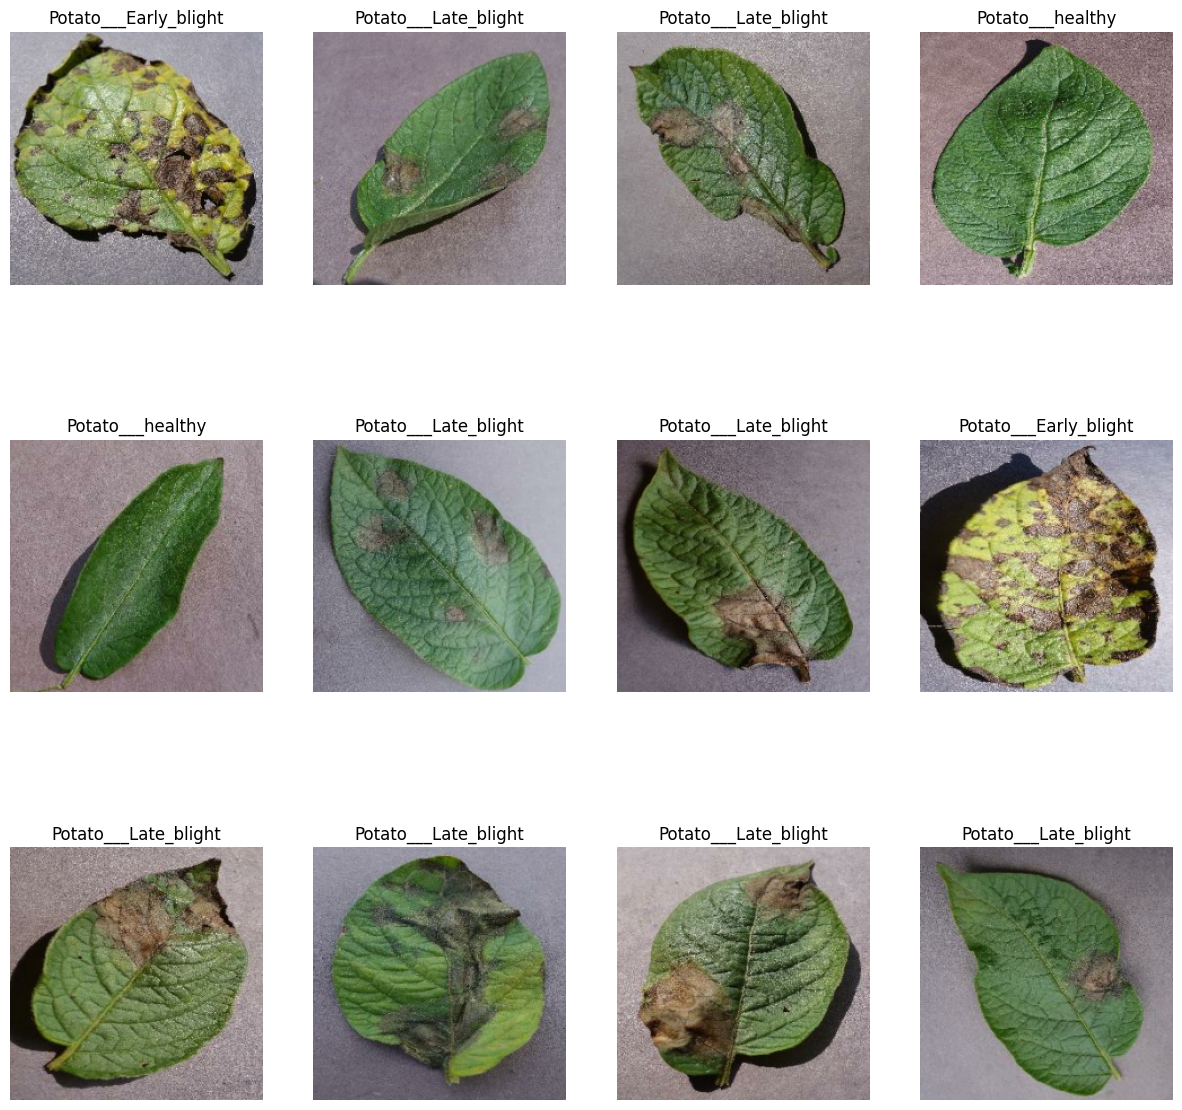

In [95]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classNames[labels_batch[i]])
        plt.axis("off")

In [96]:
len(dataset)

135

In [97]:
train_size = 0.8
len(dataset)*train_size

108.0

In [98]:
train_ds = dataset.take(54)
len(train_ds)

54

In [99]:
test_ds = dataset.skip(54)
len(test_ds)

81

In [101]:
val_size=0.1
len(dataset)*val_size

13.5

In [102]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [103]:
test_ds = test_ds.skip(6)
len(test_ds)

75

In [104]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [105]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [106]:
len(train_ds)

108

In [107]:
len(val_ds)

13

In [108]:
len(test_ds)

14

### Cache, Shuffle, and Prefetch the Dataset

In [109]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [110]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [111]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [112]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [113]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [114]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 111, 111, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 52, 52, 64)         

In [115]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [116]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=4)

In [117]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
108/108 - 46s - loss: 0.8935 - accuracy: 0.4974 - val_loss: 0.7660 - val_accuracy: 0.6325 - 46s/epoch - 422ms/step
Epoch 2/50
108/108 - 23s - loss: 0.4778 - accuracy: 0.8038 - val_loss: 0.2321 - val_accuracy: 0.8925 - 23s/epoch - 212ms/step
Epoch 3/50
108/108 - 23s - loss: 0.2661 - accuracy: 0.9013 - val_loss: 0.2940 - val_accuracy: 0.8700 - 23s/epoch - 214ms/step
Epoch 4/50
108/108 - 23s - loss: 0.1519 - accuracy: 0.9416 - val_loss: 0.1355 - val_accuracy: 0.9600 - 23s/epoch - 210ms/step
Epoch 5/50
108/108 - 23s - loss: 0.1647 - accuracy: 0.9381 - val_loss: 0.1610 - val_accuracy: 0.9425 - 23s/epoch - 211ms/step
Epoch 6/50
108/108 - 23s - loss: 0.1058 - accuracy: 0.9598 - val_loss: 0.0790 - val_accuracy: 0.9650 - 23s/epoch - 212ms/step
Epoch 7/50
108/108 - 23s - loss: 0.1473 - accuracy: 0.9482 - val_loss: 1.6411 - val_accuracy: 0.6625 - 23s/epoch - 213ms/step
Epoch 8/50
108/108 - 23s - loss: 0.1333 - accuracy: 0.9520 - val_loss: 0.1110 - val_accuracy: 0.9650 - 23s/epoch - 213

In [126]:
model.save("potato-disease.h5")

In [118]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 7s 24ms/step - loss: 0.0312 - accuracy: 0.9955


In [119]:
scores

[0.031225262209773064, 0.9955357313156128]

In [120]:
history

In [121]:
history.params

{'verbose': 2, 'epochs': 50, 'steps': 108}

In [122]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [123]:
type(history.history['loss'])

list

In [127]:
len(history.history['loss'])

15

In [128]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8935301303863525,
 0.4777960181236267,
 0.2661491334438324,
 0.1518625020980835,
 0.16467416286468506]

In [129]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

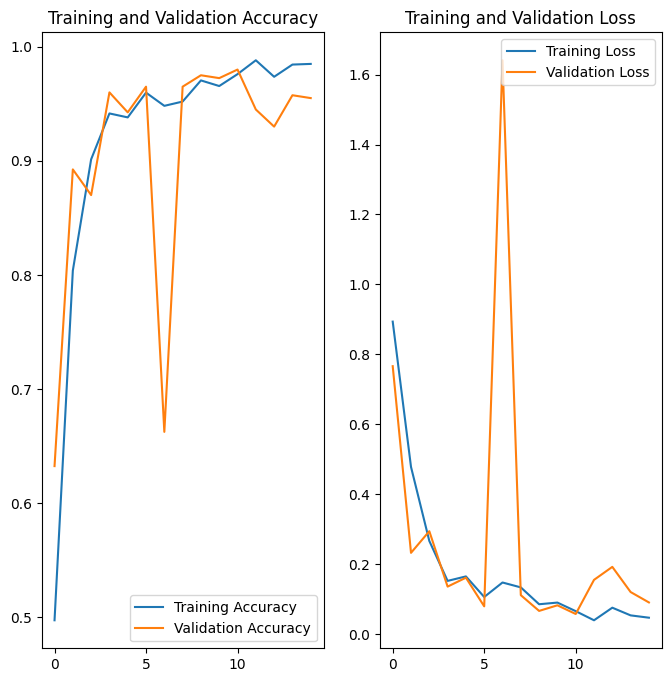

In [131]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(15), acc, label='Training Accuracy')
plt.plot(range(15), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 28ms/step
predicted label: Potato___Early_blight


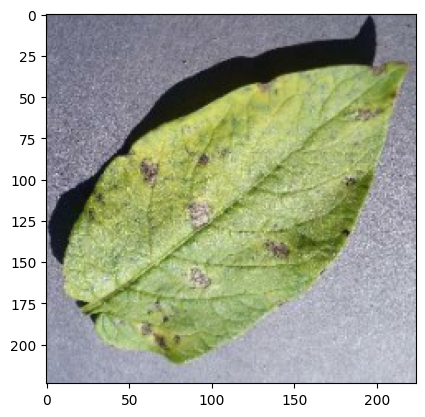

In [136]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classNames[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classNames[np.argmax(batch_prediction[0])])

In [137]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classNames[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


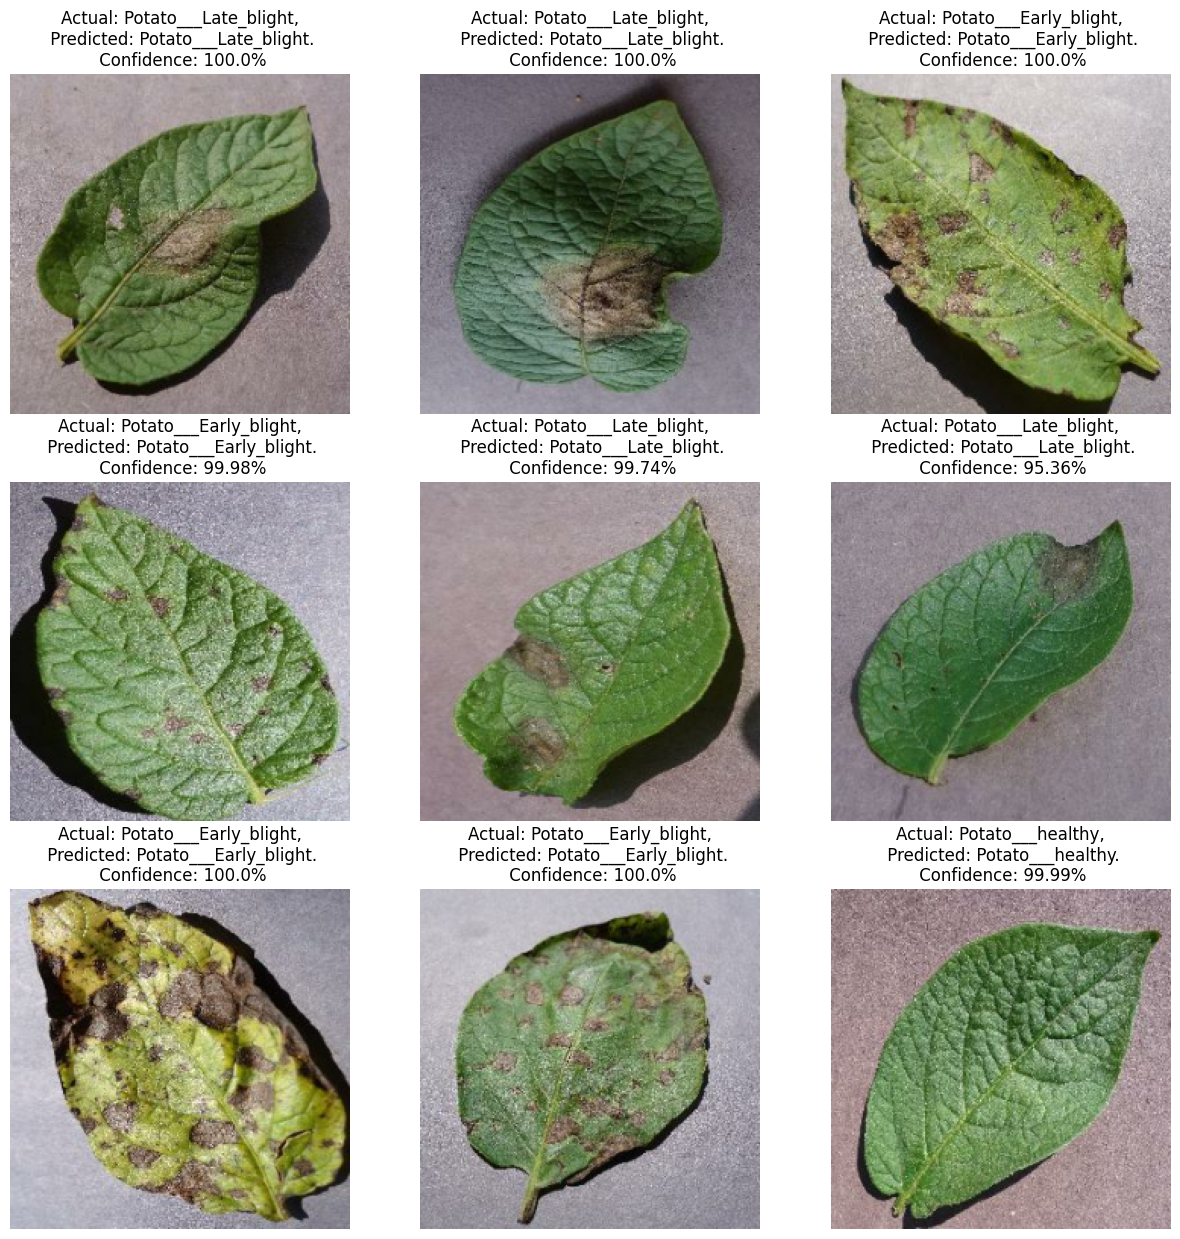

In [138]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classNames[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [124]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

FileNotFoundError: ignored

In [125]:
model.save("../potatoes.h5")